In [1]:
import h5py
import os
import numpy as np
from gGA.data import AtomicData, AtomicDataDict, OrbitalMapper
from gGA.data.interfaces import block_to_feature
from gGA.nn.hr2hk import GGAHR2HK
from gGA.utils.make_kpoints import abacus_kpath
import torch
torch.set_default_dtype(torch.float64)


root = "/nessa/users/zhanghao/dev/Hubbard/gGA/test/O4Ru2.0/"
data = AtomicData.from_points(
    atomic_numbers=np.loadtxt(os.path.join(root, "atomic_numbers.dat")),
    pos=np.loadtxt(os.path.join(root, "positions.dat")),
    r_max={"Ru": 9.52, "O": 9.52},
    cell=np.loadtxt(os.path.join(root, "cell.dat")),
    pbc=True
)
atoms = data.to_ase()

idp = OrbitalMapper(basis={"Ru": "4s2p2d1f", "O":"2s2p1d"}, spin_deg=True)

hr2k = GGAHR2HK(idp_phy=idp)
or2k = GGAHR2HK(idp_phy=idp, edge_field=AtomicDataDict.EDGE_OVERLAP_KEY, node_field=AtomicDataDict.NODE_OVERLAP_KEY, overlap=True)

kpoints, xx, _ = abacus_kpath(
    atoms,
    kpath=np.array([
        [0.0000000000,   0.0000000000,   0.0000000000,     20],
        [0.0000000000,   0.5000000000,   0.0000000000,     20],                         
        [0.5000000000,   0.5000000000,   0.0000000000,     20],             
        [0.0000000000,   0.0000000000,   0.0000000000,     20],
        [0.0000000000,   0.0000000000,   0.5000000000,     20],
        [0.0000000000,   0.5000000000,   0.5000000000,     20],
        [0.5000000000,   0.5000000000,   0.5000000000,     20],
        [0.0000000000,   0.0000000000,   0.5000000000,     1],
        [0.0000000000,   0.5000000000,   0.0000000000,     20],
        [0.0000000000,   0.5000000000,   0.5000000000,     1],
        [0.5000000000,   0.5000000000,   0.0000000000,     20],
        [0.5000000000,   0.5000000000,   0.5000000000,     1],
    ]
    )
)


In [2]:
ham = h5py.File(os.path.join(root, "hamiltonians.h5"), "r")["0"]
ovp = h5py.File(os.path.join(root, "overlaps.h5"), "r")["0"]

block_to_feature(data=data, idp=idp, blocks=ham, overlap_blocks=ovp)
data = AtomicData.to_AtomicDataDict(data)
data[AtomicDataDict.KPOINT_KEY] = torch.from_numpy(kpoints).type(torch.get_default_dtype())
data = idp(data)

In [3]:
_, ham, _ = hr2k(data)
_, ovp, _ = or2k(data)

In [4]:
chklowt = torch.linalg.cholesky(ovp)
chklowtinv = torch.linalg.inv(chklowt)
Heff = chklowtinv @ ham @ torch.transpose(chklowtinv,dim0=1,dim1=2).conj()

eigval, eigvec = torch.linalg.eigh(Heff)
efermi = 0.5 * (eigval[:,56].max() + eigval[:,56].min())

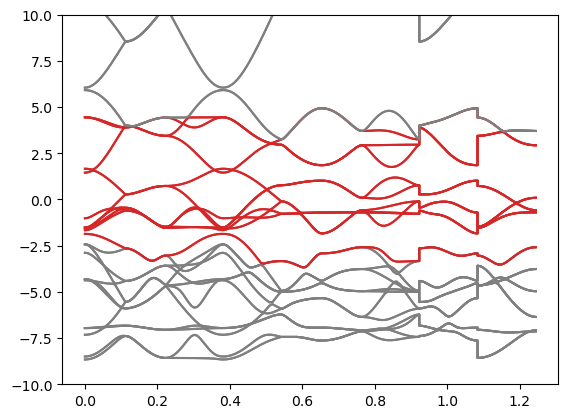

In [5]:
import matplotlib.pyplot as plt
N = 5
plt.plot(xx, eigval[:,:56-2*N]-efermi, c="tab:grey")
plt.plot(xx, eigval[:,56-2*N:56+2*N]-efermi, c="tab:red")
plt.plot(xx, eigval[:,56+2*N:]-efermi, c="tab:grey")
plt.ylim(-10,10)
plt.show()

In [6]:
amp = (eigvec * eigvec.conj()).real.mean(0).T

In [7]:
amp[56-2*N:56+2*N].sum(0).argmax()

tensor(78)

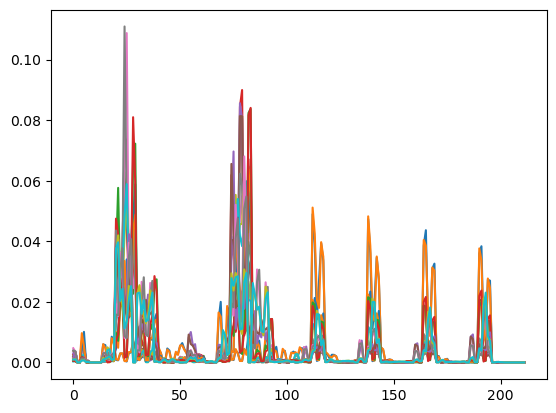

In [8]:
plt.plot(amp[56-2*N:56+2*N].T)
plt.show()

In [9]:
atoms.get_atomic_numbers()

array([44, 44,  8,  8,  8,  8])

In [10]:
from gGA.data import block_to_feature
from ase.io import read
from gGA.data import AtomicData
from gGA.utils.make_kpoints import kmesh_sampling
import torch
from gGA.nn.ghostG import GhostGutzwiller
from gGA.utils.tools import setup_seed
from gGA.data.transforms import OrbitalMapper

# setup_seed(1234)

torch.set_default_dtype(torch.float64)
U = 0.1
J = 0. # 0.25 * U
Up = U - 2*J
Jp = J

gga = GhostGutzwiller(
    atomic_number=torch.tensor([44, 44,  8,  8,  8,  8]),
    nocc=56,
    basis={"Ru":"4s2p2d1f", "O":"2s2p1d"},
    idx_intorb={"Ru":[6]},
    naux=1,
    intparams={"Ru":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]},
    nspin=1,
    device=torch.device("cpu"),
    kBT=0.0002,
    overlap=True,
    mutol=1e-4,
    solver="ED",
    mixer_options={"method": "Linear", "a": 0.3},
    iscomplex=True,
    solver_options={}# {"mfepmin":500, "channels": 10},
)


data["kpoint"] = torch.tensor(kmesh_sampling([10,10,14], True)).to(torch.get_default_dtype())

In [11]:
gga.run(data, 200, 1e-3)

DM_kin:  tensor([0.0011, 0.0011, 0.0013, 0.0013, 0.0015, 0.0015, 0.0016, 0.0016, 0.0017,
        0.0017, 0.0019, 0.0019, 0.0020, 0.0020, 0.0021, 0.0021, 0.0022, 0.0022,
        0.0023, 0.0023, 0.0024, 0.0024, 0.0027, 0.0027, 0.0028, 0.0028, 0.0030,
        0.0030, 0.0031, 0.0031, 0.0033, 0.0033, 0.0036, 0.0036, 0.0037, 0.0037,
        0.0041, 0.0041, 0.0042, 0.0042, 0.0047, 0.0047, 0.0051, 0.0051, 0.0060,
        0.0060, 0.0061, 0.0061, 0.0065, 0.0065, 0.0066, 0.0066, 0.0071, 0.0071,
        0.0073, 0.0073, 0.0076, 0.0076, 0.0080, 0.0080, 0.0089, 0.0089, 0.0097,
        0.0097, 0.0103, 0.0103, 0.0125, 0.0125, 0.0135, 0.0135, 0.0151, 0.0151,
        0.0158, 0.0158, 0.0166, 0.0166, 0.0181, 0.0181, 0.0193, 0.0193, 0.0200,
        0.0200, 0.0221, 0.0221, 0.0263, 0.0263, 0.0278, 0.0278, 0.0288, 0.0288,
        0.0294, 0.0294, 0.0325, 0.0325, 0.0353, 0.0353, 0.0377, 0.0377, 0.0386,
        0.0386, 0.0418, 0.0418, 0.0485, 0.0485, 0.0508, 0.0508, 0.0536, 0.0536,
        0.0560, 0.0560, 0.0667,

_LinAlgError: linalg.eigh: (Batch element 0): The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 210).